<a href="https://colab.research.google.com/github/reeveboy/fantasy-premier-league-analytics/blob/main/feature_engineering_%26_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/datasets/FPL/clean_data.csv')

In [ ]:
data_df.drop(['Unnamed: 0', 'fixture', 'round', 'kickoff_time'], axis=1, inplace=True)

In [ ]:
data_df.rename(columns={
    'opponent_team': 'opponent',
    'GW': 'gameweek',
    'total_points': 'points',
    'minutes': 'minutes_played',
}, inplace=True)

## Now let's do Feature Engineering!

I honestly got too excited and got carried away and ended up adding a bunch of features

In [ ]:
def calc_result(row):
    if (row['was_home'] and (row['team_h_score'] > row['team_a_score'])) or ((not row['was_home']) and (row['team_a_score'] > row['team_h_score'])):
        return 'W'
    elif (row['was_home'] and (row['team_h_score'] < row['team_a_score'])) or ((not row['was_home']) and (row['team_a_score'] < row['team_h_score'])):
        return 'L'
    return 'D'

# Add win/loss/draw column based on match result
data_df['result'] = data_df.apply(calc_result, axis=1)

In [ ]:
def add_sliding_window_features(df, window_size):
  df_index = df.assign(index=df.index)

  features = []
  for season, player_data in df_index.groupby(['season', 'name']):
    player_data = player_data.sort_values(by='gameweek')  # Sort by gameweek

    window_data = []
    total_points = total_minutes_played = total_yellow_cards = total_red_cards = total_goals_scored = total_assists = total_clean_sheets = total_saves = total_penalties_saved = total_wins = total_losses = total_draws = team_goals_scored = team_goals_conceded = 0
    for i, row in player_data.iterrows():
      # Append current row data to window
      window_data.append(row.to_dict())  # Convert row to dictionary for window

      # Calculate features, and append
      new_features = calculate_features(window_data, window_size, row['index'], row['position'])

      total_points += row['points']
      total_minutes_played += row['minutes_played']
      total_yellow_cards += row['yellow_cards']
      total_red_cards += row['red_cards']
      total_goals_scored += row['goals_scored']
      total_assists += row['assists']
      total_clean_sheets += row['clean_sheets']
      total_saves += row['saves']
      total_penalties_saved += row['penalties_saved']
      total_wins += 1 if row['result'] == 'W' else 0
      total_losses += 1 if row['result'] == 'L' else 0
      total_draws += 1 if row['result'] == 'D' else 0
      team_goals_scored += row['team_h_score'] if row['was_home'] else row['team_a_score']
      team_goals_conceded += row['team_a_score'] if row['was_home'] else row['team_h_score']

      new_features.update({
          'total_points': total_points,
          'total_minutes_played': total_minutes_played,
          'total_yellow_cards': total_yellow_cards,
          'total_red_cards': total_red_cards,
          'total_goals_scored': total_goals_scored,
          'total_assists': total_assists,
          'total_saves': total_saves,
          'total_penalties_saved': total_penalties_saved,
          'total_wins': total_wins,
          'total_losses': total_losses,
          'total_draws': total_draws,
          'team_goals_scored': team_goals_scored,
          'team_goals_conceded': team_goals_conceded,
        })
      features.append(new_features)

      # Check if window size is reached
      if len(window_data) == window_size:
        window_data.pop(0)  # Slide the window

  # Combine features with original data
  df_with_features = pd.merge(df_index, pd.DataFrame(features), on='index', how='inner').drop('index', axis=1)
  return df_with_features

# Function to calculate features based on the window data (replace with your calculations)
def calculate_features(window_data, window_size, index, position):
  weight = len(window_data) / window_size

  n_games = len(window_data)

  position_weights = {'FWD': 1.0, 'MID': 1.2, 'DEF': 1.4, 'GK': 1.6}

  # Extract relevant features for form calculation
  total_points = total_minutes = total_yellow_cards = total_red_cards = total_goals_conceded = total_own_goals = total_goals_scored = total_assists = total_clean_sheets = total_saves = total_value = total_transfers_balance = total_selected = total_wins = total_losses = total_draws = team_goals_scored = team_goals_conceded = total_ict = 0

  for row in window_data:
    total_points += row['points']
    total_minutes += row['minutes_played']
    total_yellow_cards += row['yellow_cards']
    total_red_cards += row['red_cards']
    total_goals_conceded += row['goals_conceded']
    total_own_goals += row['own_goals']
    total_goals_scored += row['goals_scored']
    total_assists += row['assists']
    total_clean_sheets += row['clean_sheets']
    total_saves += row['saves']
    total_value += row['value']
    total_transfers_balance += row['transfers_balance']
    total_selected += row['selected']
    total_wins += 1 if row['result'] == 'W' else 0
    total_losses += 1 if row['result'] == 'L' else 0
    total_draws += 1 if row['result'] == 'D' else 0
    team_goals_scored += row['team_h_score'] if row['was_home'] else row['team_a_score']
    team_goals_conceded += row['team_a_score'] if row['was_home'] else row['team_h_score']
    total_ict = row['ict_index']

  total_minutes_per_90 = total_minutes / 90
  avg_value = total_value / n_games
  avg_transfer_balance = total_transfers_balance / n_games
  avg_selected = total_selected / n_games
  team_form = ((total_wins * 1.5) + (total_draws * 0.5) + (total_losses * -1)) * weight

  # Calculate form (consider cases where minutes might be missing)
  if total_minutes_per_90 == 0:
    total_minutes_per_90 = 1

  form = ((total_points + total_ict) / n_games) * weight * position_weights[position]
  heat = ((total_yellow_cards + total_red_cards + total_goals_conceded + total_own_goals) / n_games) * weight
  goal_involvement = ((total_goals_scored + total_assists) / n_games) * weight * position_weights[position]
  defensive_contribution = ((total_clean_sheets + total_saves) / n_games) * weight * position_weights[position]
  value_for_price = ((total_points / avg_value) / n_games) * weight * position_weights[position]
  minutes_per_game = (total_minutes_per_90 / n_games) * weight
  popularity = (avg_transfer_balance / (avg_selected + 1e6)) * weight
  offensive_score = (team_goals_scored / n_games) * weight * position_weights[position]
  defensive_score = ((team_goals_conceded + total_clean_sheets) / n_games) * weight * position_weights[position]

  return {
      'index': index,
      'form': form,
      'heat': heat,
      'goal_involvement': goal_involvement,
      'defensive_contribution': defensive_contribution,
      'value_for_price': value_for_price,
      'minutes_per_game': minutes_per_game,
      'team_form': team_form,
      'team_offensive_score': offensive_score,
      'team_defensive_score': defensive_score,
    }

new_data = add_sliding_window_features(data_df, 5)

In [ ]:
new_data.shape

(185295, 56)

In [ ]:
numeric_cols = new_data.select_dtypes(include=['number'])
numeric_cols.drop(['gameweek', 'points',], axis=1, inplace=True)

In [ ]:
numeric_cols.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'minutes_played', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score',
       'threat', 'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards', 'form', 'heat', 'goal_involvement',
       'defensive_contribution', 'value_for_price', 'minutes_per_game',
       'team_form', 'team_offensive_score', 'team_defensive_score',
       'total_points', 'total_minutes_played', 'total_yellow_cards',
       'total_red_cards', 'total_goals_scored', 'total_assists', 'total_saves',
       'total_penalties_saved', 'total_wins', 'total_losses', 'total_draws',
       'team_goals_scored', 'team_goals_conceded'],
      dtype='object')

### Using Correlation to select features

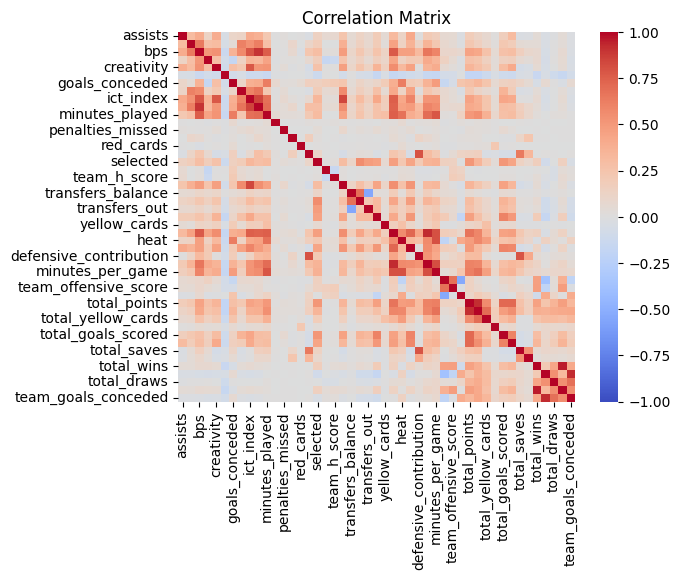

In [ ]:
# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm')

# Customize the plot (optional)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Set the threshold for correlation
threshold = 0.75  # You can adjust this threshold as needed

# Create a list to store highly correlated features
highly_correlated_features = []

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            # Check if the correlation is above the threshold
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            highly_correlated_features.append((feature1, feature2, correlation))

# Print highly correlated features
for feature1, feature2, correlation in highly_correlated_features:
    print(f"{feature1} and {feature2} are highly correlated: {correlation}")


bps and ict_index are highly correlated: 0.7824038001502858
bps and influence are highly correlated: 0.9009472723553335
bps and minutes_played are highly correlated: 0.7610450156329109
bps and form are highly correlated: 0.7686452671250374
creativity and ict_index are highly correlated: 0.7755281432409998
ict_index and influence are highly correlated: 0.8474938188039435
ict_index and threat are highly correlated: 0.8367377733355079
ict_index and form are highly correlated: 0.7533376089192904
minutes_played and form are highly correlated: 0.7567359078825014
minutes_played and minutes_per_game are highly correlated: 0.7812557720012545
saves and defensive_contribution are highly correlated: 0.7986983615660237
form and value_for_price are highly correlated: 0.9268870370726222
form and minutes_per_game are highly correlated: 0.8068030609772222
heat and minutes_per_game are highly correlated: 0.8079081944479642
defensive_contribution and total_saves are highly correlated: 0.7904548960661344


By looking at this i think **bps, creativity, influence, threat, total_minutes_played, total_wins, total_losses** can be removed

### Using Variance Inflation Factor to detect multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

# Print the VIF values
print("VIF values for each feature:")
for i, v in enumerate(vif):
  print(f"{numeric_cols.columns[i]}: {v:.2f}")

# Identify features with high VIF (> 5)
high_vif_features = [numeric_cols.columns[i] for i, v in enumerate(vif) if v > 5]

if high_vif_features:
  print("\nFeatures with high VIF (> 5):")
  print(high_vif_features)
else:
  print("\nNo features with high VIF detected.")

VIF values for each feature:
assists: 2.03
bonus: 2.46
bps: 16.61
clean_sheets: 2.82
creativity: 1147.42
element: 3.73
goals_conceded: 4.74
goals_scored: 5.27
ict_index: 9965.00
influence: 1813.19
minutes_played: 15.31
own_goals: 1.01
penalties_missed: 1.02
penalties_saved: 1.11
red_cards: 1.08
saves: 3.83
selected: 2.76
team_a_score: 2.63
team_h_score: 3.14
threat: 1666.42
transfers_balance: 595997.27
transfers_in: 460311.52
transfers_out: 355028.49
value: 13.54
yellow_cards: 1.33
form: 122.27
heat: 8.33
goal_involvement: 8.08
defensive_contribution: 8.02
value_for_price: 48.83
minutes_per_game: 23.96
team_form: 7.09
team_offensive_score: 17.46
team_defensive_score: 16.74
total_points: 73.84
total_minutes_played: 45.72
total_yellow_cards: 3.74
total_red_cards: 1.15
total_goals_scored: 7.48
total_assists: 4.86
total_saves: 4.50
total_penalties_saved: 1.51
total_wins: 48.58
total_losses: 41.14
total_draws: 7.10
team_goals_scored: 80.14
team_goals_conceded: 80.06

Features with high VIF 

Seem like we hace to drop a bunch of these

### Selecting useful features by using Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

X = numeric_cols
y = data_df['points']

# Assuming X is your features data and y is points for the next game
lasso_model = Lasso(alpha=0.01)  # Adjust alpha hyperparameter as needed
lasso_model.fit(X, y)

# Select features based on model coefficients
feature_selector = SelectFromModel(lasso_model, prefit=True)  # Pre-fit the model
X_reduced = feature_selector.transform(X)

# Get selected features
selected_features = X.columns[feature_selector.get_support()]

not_selected = [feature for feature in X.columns if feature not in selected_features]
print(f"Features not selected by Lasso regression: \n{not_selected}\n")

Features not selected by Lasso regression: 
['element', 'ict_index', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'selected', 'team_a_score', 'transfers_balance', 'transfers_in', 'transfers_out', 'heat', 'goal_involvement', 'defensive_contribution', 'value_for_price', 'team_offensive_score', 'total_yellow_cards', 'total_red_cards', 'total_assists', 'total_saves', 'total_penalties_saved', 'total_wins', 'total_losses', 'total_draws']



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.302e+03, tolerance: 1.123e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


After some short careful thinking I decide these will go

In [ ]:
dropped_cols = [
    'own_goals',
    'penalties_missed',
    'penalties_saved',
    'saves',
    'total_saves',
    'yellow_cards',
    'red_cards',
    'selected',
    'team_a_score',
    'team_h_score',
    'bps',
    'ict_index',
    'minutes_played',
    'transfers_balance',
    'value',
    'transfers_in',
    'transfers_out',
    'creativity',
    'influence',
    'threat',
    'total_penalties_saved',
    'total_minutes_played',
    'total_red_cards',
    'total_wins',
    'total_losses',
    'total_draws',
    'team_goals_scored',
    'team_goals_conceded',
    # 'total_points',
]
data = new_data.drop([cols for cols in dropped_cols if cols in new_data.columns], axis=1)

In [ ]:
data.columns

Index(['name', 'assists', 'bonus', 'clean_sheets', 'element', 'goals_conceded',
       'goals_scored', 'points', 'was_home', 'gameweek', 'season', 'position',
       'team', 'opponent', 'result', 'form', 'heat', 'goal_involvement',
       'defensive_contribution', 'value_for_price', 'minutes_per_game',
       'team_form', 'team_offensive_score', 'team_defensive_score',
       'total_points', 'total_yellow_cards', 'total_goals_scored',
       'total_assists'],
      dtype='object')

### Preping the data for training

Cleaning up a few things before I dig into the processing

In [ ]:
data = data[data['gameweek'] <= 38]
data.loc[data['team'] == 'Sheffield Utd', 'team'] = 'Sheffield United'
data.loc[data['opponent'] == 'Huddersfield', 'opponent'] = 'Huddersfield Town'
data.loc[data['opponent'] == 'West Brom', 'opponent'] = 'West Bromwich Albion'
data.loc[:, 'team'] = data['team'].str.lower().str.replace(' ', '_')
data.loc[:, 'opponent'] = data['opponent'].str.lower().str.replace(' ', '_')

This code will generate the next_opponent and the next_points(y) that a player will score

In [ ]:
# Sort the DataFrame by season, name, and gameweek
data_sorted = data.sort_values(by=['season', 'name', 'gameweek'])

# Group the sorted DataFrame by season and name
grouped = data_sorted.groupby(['season', 'name'])

# Define a function to add next opponent and next points
def add_next_opponent_points(group):
    group['next_opponent'] = group['opponent'].shift(-1)
    group['next_points'] = group['points'].shift(-1)
    return group

# Apply the function to each group and handle None values for last entry in each group
preped_data = grouped.apply(add_next_opponent_points).fillna({'next_opponent': 'None', 'next_points': 0})

# Reset index to bring DataFrame back to ungrouped form
preped_data.reset_index(drop=True, inplace=True)

Let's have a look at how the data looks

In [ ]:
preped_data.loc[preped_data['name'] == 'Kevin De Bruyne', ['name', 'points', 'opponent', 'next_points', 'next_opponent', 'season', 'gameweek']]

,name,points,opponent,next_points,next_opponent,season,gameweek
13257,Kevin De Bruyne,2,sunderland,4.0,stoke_city,2016/17,1
13258,Kevin De Bruyne,4,stoke_city,6.0,west_ham_united,2016/17,2
13259,Kevin De Bruyne,6,west_ham_united,13.0,manchester_united,2016/17,3
13260,Kevin De Bruyne,13,manchester_united,14.0,afc_bournemouth,2016/17,4
13261,Kevin De Bruyne,14,afc_bournemouth,10.0,swansea_city,2016/17,5
...,...,...,...,...,...,...,...
171083,Kevin De Bruyne,7,burnley,5.0,brentford,2023/24,22
171084,Kevin De Bruyne,5,brentford,4.0,everton,2023/24,23
171085,Kevin De Bruyne,4,everton,2.0,chelsea,2023/24,24
171086,Kevin De Bruyne,2,chelsea,0.0,brentford,2023/24,25


That seems good enough.

Now to handle empty data

In [ ]:
print(f"Gotta remove these empty rows: {len(preped_data.loc[preped_data['next_opponent'] == 'None'])}")
preped_data = preped_data[preped_data['next_opponent'] != 'None']

Gotta remove these empty rows: 5626


### Encoding the Categorical Features

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoded_data = preped_data.copy().drop('name', axis=1)

# Label Encoding (for Linear Regression)
categorical_features_le = ['season', 'gameweek', 'was_home', 'position', 'result']  # Features for Label Encoding
le = LabelEncoder()
for col in categorical_features_le:
  encoded_data[col] = le.fit_transform(encoded_data[col])

# One-Hot Encoding with pd.get_dummies
categorical_features_ohe = ['team', 'opponent', 'next_opponent']
encoded_data = pd.get_dummies(encoded_data, columns=categorical_features_ohe, drop_first=True)

#### Splitting the data for training and testing chronologically and also scalling the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Split data into training and testing sets (chronological split)
train_data, test_data = train_test_split(encoded_data, test_size=0.2, shuffle=False)  # Shuffle=False for time-series

# Separate features and target
X_train = train_data.drop('next_points', axis=1)
y_train = train_data['next_points']
X_test = test_data.drop('next_points', axis=1)
y_test = test_data['next_points']

# Apply RobustScaler to training and testing data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Let's commence the training

First Up, Linear Regression. This bad boy is the favourite of our Professor. Well Gemini thinks it won't perform well for this task. I guess let's find out!

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create and fit the linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Use the trained model to predict points on the testing set
y_pred = lr.predict(X_test_scaled)

# Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Root Mean Squared Error: 1.9568
Mean Absolute Error: 1.0832


Well I don't really know why but gemini thinks Linear Regression sucks

Now, lets go to Random Forest. Lets see if these bunch of trees are up to any good. (It takes a long time to fit the model, hope that's a good sign)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit the Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

# Predict points on the testing set
y_pred = rf.predict(X_test_scaled)

# Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Root Mean Squared Error: 1.9980
Mean Absolute Error: 1.1210


XGBoost, oh I've heard so much about you. Let's see how you perform

In [ ]:
from xgboost import XGBRegressor

# Create and fit the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror')  # Set objective for regression
xgb.fit(X_train_scaled, y_train)

# Predict points on the testing set
y_pred = xgb.predict(X_test_scaled)

# Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Root Mean Squared Error: 1.9669
Mean Absolute Error: 1.0404


What a sham. Both random forest and xgboost had high expectation but the results are rather underwhelming.

Let's bring in the big guns, a neural network now

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1

# Define model architecture
nn = Sequential()
nn.add(Dense(units=128, activation='relu', input_shape=(X_train_scaled.shape[1],)))  # Input layer with number of features
nn.add(Dropout(rate=0.2))                                                     # Dropout layer with 20% dropout rate
nn.add(Dense(units=64, activation='relu', kernel_regularizer=l1(l=0.001)))    # Hidden layer with 64 neurons
nn.add(Dropout(rate=0.2))                                                     # Dropout layer with 20% dropout rate
nn.add(Dense(units=1))                                                        # Output layer with 1 neuron for predicted points

# Compile the model
nn.compile(loss='mse', optimizer='adam')

# Train the model
nn.fit(X_train_scaled, y_train, epochs=20, batch_size=32)

# Make predictions on the testing set
y_pred = nn.predict(X_test_scaled)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Epoch 1/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.9509
Epoch 2/20
4342/4342 [==============================] - 11s 3ms/step - loss: 4.6162
Epoch 3/20
4342/4342 [==============================] - 11s 3ms/step - loss: 4.5456
Epoch 4/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.4991
Epoch 5/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.4889
Epoch 6/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.4631
Epoch 7/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.4510
Epoch 8/20
4342/4342 [==============================] - 13s 3ms/step - loss: 4.4245
Epoch 9/20
4342/4342 [==============================] - 12s 3ms/step - loss: 4.3939
Epoch 10/20
4342/4342 [==============================] - 11s 3ms/step - loss: 4.3760
Epoch 11/20
4342/4342 [==============================] - 11s 3ms/step - loss: 4.3597
Epoch 12/20
4342/4342 [==============================] - 11s 3ms/step - lo

I can't say I expected this. But ig it is best overall